In [ ]:
import sys
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
sys.path.append(os.path.abspath(".."))  #TODO: MAKE THE SRC PACKAGE WORK
from src.training.new_optimised_train import train_autoencoder, train_cellfate
from src.evaluation.evaluate import *
from src.training.loss_functions import *
from src.preprocessing.preprocessing_functions import *
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from src.models import Encoder, Decoder, Discriminator, mlp_classifier, complex_mlp_classifier
from tensorflow.keras import layers, Sequential
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

# AICellFate model with image data

In [1]:
# TODO: add the workflow from manuscript notebook that gives us the final confusion matrix values per random state per time point

In [ ]:
# load all confusion matrices

conf_matrix_cellfate_seed42 = np.sum((np.load('all_confusion_matrices_cellfate_6.npy'), np.load('all_confusion_matrices_cellfate_10.npy')), axis=0)
conf_matrix_cellfate_seed43 = np.sum((np.load('all_confusion_matrices_cellfate_seed43_3.npy'), np.load('all_confusion_matrices_cellfate_seed43_6.npy'), np.load('all_confusion_matrices_cellfate_seed43_10.npy')), axis=0)
conf_matrix_cellfate_seed44 = np.sum((np.load('all_confusion_matrices_cellfate_seed44_4.npy'), np.load('all_confusion_matrices_cellfate_seed44_10.npy')), axis=0)

conf_matrix_cellfate = np.stack((conf_matrix_cellfate_seed42, conf_matrix_cellfate_seed43, conf_matrix_cellfate_seed44), axis=0)

In [50]:
conf_matrix_cellfate[0,0][0,1]

0.34234234234234234

In [51]:
# calculate precisions

precision_cellfate = np.zeros((11, 3))
accuracy_cellfate = np.zeros((11, 3))
false_positives_cellfate = np.zeros((11, 3))
false_negatives_cellfate = np.zeros((11, 3))

for tp in range(conf_matrix_cellfate.shape[1]):
    for seed in range(conf_matrix_cellfate.shape[0]):
        conf_matrix = conf_matrix_cellfate[seed, tp]
        precision_cellfate[tp, seed] = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[1,0])
        accuracy_cellfate[tp, seed] = (conf_matrix[0,0] + conf_matrix[1,1]) / np.sum(conf_matrix)
        false_positives_cellfate[tp, seed] = conf_matrix[1,0] #/ np.sum(conf_matrix[1,:])
        false_negatives_cellfate[tp, seed] = conf_matrix[0,1] #/ np.sum(conf_matrix[0,:])

In [59]:
mean_precisions = np.mean(precision_cellfate, axis=1)
std_precisions = np.std(precision_cellfate, axis=1)

mean_accuracies = np.mean(accuracy_cellfate, axis=1)
std_accuracies = np.std(accuracy_cellfate, axis=1)

mean_false_positives = np.mean(false_positives_cellfate, axis=1)
std_false_positives = np.std(false_positives_cellfate, axis=1)

mean_false_negatives = np.mean(false_negatives_cellfate, axis=1)
std_false_negatives = np.std(false_negatives_cellfate, axis=1)

Plotting results of our model

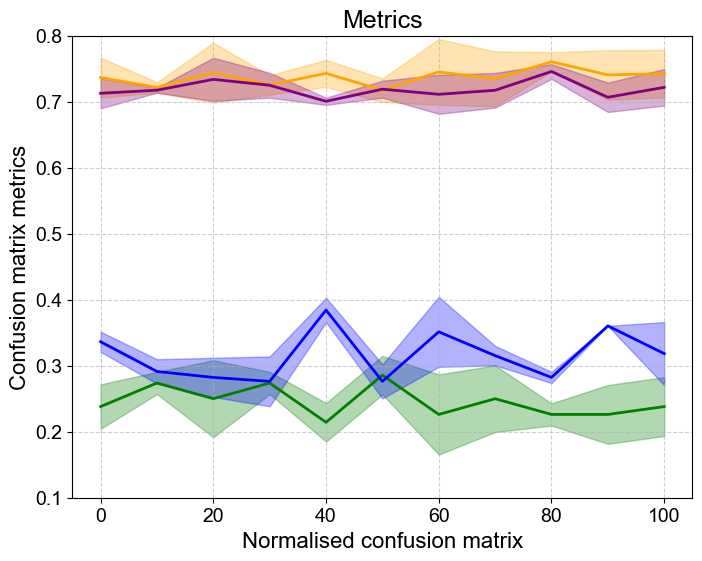

In [60]:
time_points = np.linspace(0, 100, len(mean_precisions))

# Plot
plt.figure(figsize=(8, 6))

# Precision (orange)
plt.plot(time_points, mean_precisions, color='orange', linewidth=2)
plt.fill_between(time_points, mean_precisions - std_precisions, mean_precisions + std_precisions,
                 color='orange', alpha=0.3)

# Accuracy (purple)
plt.plot(time_points, mean_accuracies, color='purple', linewidth=2)
plt.fill_between(time_points, mean_accuracies - std_accuracies, 
                 mean_accuracies + std_accuracies, color='purple', alpha=0.3)

# False Positives (green)
plt.plot(time_points, mean_false_positives, color='green', linewidth=2)
plt.fill_between(time_points, mean_false_positives - std_false_positives,
                 mean_false_positives + std_false_positives, color='green', alpha=0.3)

# False Negatives (blue)
plt.plot(time_points, mean_false_negatives, color='blue', linewidth=2)
plt.fill_between(time_points, mean_false_negatives - std_false_negatives,
                    mean_false_negatives + std_false_negatives, color='blue', alpha=0.3)

# Formatting
plt.xlabel("Normalised confusion matrix", fontsize=16, fontname="Arial")
plt.ylabel("Confusion matrix metrics", fontsize=16, fontname="Arial")
plt.title("Metrics", fontsize=18, fontname="Arial")
plt.xticks(fontsize=14, fontname="Arial")
plt.yticks(fontsize=14, fontname="Arial")
plt.ylim(0.1, 0.8)  # Set y-axis range
plt.grid(True, linestyle="--", alpha=0.6)

# Save the figure with high quality
#plt.savefig("precision_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

# MLP model with tabular data

In [ ]:
# TODO: add the workflow from manuscript notebook that gives us the final confusion matrix values per random state per time point

In [ ]:
# tabular_train = np.load('../data/tracks/time_norm_train_track.npy') ### THIS WASNT DONE CORRECTLY
# tabular_test = np.load('../data/tracks/time_norm_test_track.npy')
# train_labels = np.load("../data/labels/train_labels.npy")
# test_labels = np.load("../data/labels/test_labels.npy")

In [128]:
test_labels = np.load('../data/labels/test_labels.npy')
train_tracks = np.load("../data/tracks/train_tracks.npy")
train_labels = np.load("../data/labels/train_labels.npy")
test_tracks = np.load("../data/tracks/test_tracks.npy")

In [129]:
train_tracks_features = train_tracks[:, :, 4:17 ] 
test_tracks_features = test_tracks[:, :, 4:17]

In [130]:
def normalize_cell_time(data):
    """
    Normalize cell time by extracting feature values at 0%, 10%, ..., 100% 
    of each cell's lifetime.
    
    Parameters:
    - data: numpy array of shape (cells, time points, features)
      (assumes the first feature is used to determine lifetime)
    
    Returns:
    - normalized_data: numpy array of shape (cells, 11, features)
    """
    num_cells, num_timepoints, num_features = data.shape
    normalized_data = np.zeros((num_cells, 11, num_features))

    for i in range(num_cells):
        # Determine lifetime (number of nonzero values in the first feature)
        lifetime = np.count_nonzero(data[i, :, 0])

        if lifetime == 0:
            continue  # Skip cells that are all zero

        # Compute the indices corresponding to 0%, 10%, ..., 100% of the lifetime
        indices = np.round(np.linspace(0, lifetime - 1, 11)).astype(int)
        print(indices)
        # Extract feature values at these indices
        normalized_data[i] = data[i, indices, :]

    return normalized_data

In [ ]:
train_tracks_norm = normalize_cell_time(train_tracks_features)

[   0  108  216  324  432  540  647  755  863  971 1079]
[  0  33  66  98 131 164 197 230 262 295 328]
[  0  27  53  80 106 133 160 186 213 239 266]
[  0  60 120 179 239 299 359 419 478 538 598]
[ 0  4  8 12 16 20 23 27 31 35 39]
[  0  42  83 124 166 208 249 290 332 374 415]
[  0  50 101 151 202 252 302 353 403 454 504]
[  0  40  79 118 158 198 237 276 316 356 395]
[   0  108  216  324  432  540  647  755  863  971 1079]
[   0  108  216  324  432  540  647  755  863  971 1079]
[   0  108  216  324  432  540  647  755  863  971 1079]
[  0  60 119 179 238 298 358 417 477 536 596]
[   0  108  216  324  432  540  647  755  863  971 1079]
[   0  108  216  324  432  540  647  755  863  971 1079]
[   0  108  216  324  432  540  647  755  863  971 1079]
[   0  108  216  324  432  540  647  755  863  971 1079]
[   0  108  216  324  432  540  647  755  863  971 1079]
[  0  96 191 286 382 478 573 668 764 860 955]
[   0  108  216  324  432  540  647  755  863  971 1079]
[   0  107  215  322  430  

In [156]:
test_tracks_norm = normalize_cell_time(test_tracks_features)

[   0  108  216  324  432  540  647  755  863  971 1079]
[   0  108  216  324  432  540  647  755  863  971 1079]
[   0  108  216  324  432  540  647  755  863  971 1079]
[   0  107  215  322  430  537  644  752  859  967 1074]
[  0  90 180 270 360 450 540 630 720 810 900]
[   0  108  216  324  432  540  647  755  863  971 1079]
[   0  108  216  324  432  540  647  755  863  971 1079]
[   0  108  216  324  432  540  647  755  863  971 1079]
[   0  108  216  324  432  540  647  755  863  971 1079]
[   0  100  200  300  400  500  601  701  801  901 1001]
[  0  13  25  38  50  63  76  88 101 113 126]
[   0  108  216  324  432  540  647  755  863  971 1079]
[   0  108  216  324  432  540  647  755  863  971 1079]
[   0  104  209  314  418  522  627  732  836  940 1045]
[   0  108  216  324  432  540  647  755  863  971 1079]
[  0  24  48  72  96 120 143 167 191 215 239]
[  0  96 191 287 383 478 574 670 766 861 957]
[   0  108  216  324  432  540  647  755  863  971 1079]
[   0  108  216  3

In [159]:
np.nonzero(test_tracks_norm[:,0] == test_tracks_features[:,0])

(array([  0,   0,   0, ..., 276, 276, 276]),
 array([ 0,  1,  2, ..., 10, 11, 12]))

In [143]:
train_tracks_features[15,0]

array([0.0000000e+00, 3.3984201e+02, 3.8268210e+02, 2.2496056e+02,
       2.4090036e+02, 1.1483401e+01, 9.7401609e+00, 5.2968448e-01,
       1.0341766e+01, 3.1377001e+01, 7.2252411e+02, 8.4000000e+01,
       1.1789745e+00], dtype=float32)

In [145]:
train_tracks_norm[15,0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [174]:
# find how many cells are zero 

for cell in range(train_tracks_norm.shape[0]):
    if np.all(train_tracks_norm[cell] == 0):
        print(cell)

1
15
31
310
328
342
428
471
497
624
629
869
915
963
966


In [186]:
# Remove all cells that are all zeros across all timepoints and features
train_tracks_norm_filtered = train_tracks_norm[~(np.all(train_tracks_norm == 0, axis=(1, 2)))]
test_tracks_norm_filtered = test_tracks_norm[~(np.all(test_tracks_norm == 0, axis=(1, 2)))]

In [187]:
test_tracks_norm_filtered.shape

(272, 11, 13)

In [ ]:
def complex_mlp_classifier(latent_dim): 
    return Sequential([
        layers.Input(shape=(latent_dim,)),
        layers.BatchNormalization(),
        layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        layers.Dropout(0.3),
        layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        layers.Dropout(0.3),
        layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        layers.Dropout(0.3),
        layers.Dense(2, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(1e-4))
    ])

In [193]:
train_tracks[:,:,4:17].shape

(1108, 1080, 13)

In [190]:
conf_matrix_tabular = np.zeros((3, 11, 2, 2)) # 3 random states, 11 time points, 2x2 confusion matrix

config = {
    'batch_size': 30,
    'epochs': 50,
    'learning_rate': 0.001,
    'seed': 42,
}

for seed in [42, 43, 44]:
    for i in range(train_tracks_norm.shape[1]): #tabular_train.shape[1]
        frame = i
        class_weights = compute_class_weight('balanced', classes=np.unique(train_labels[~(np.all(train_tracks_norm == 0, axis=(1, 2)))].flatten()), y=train_labels[~(np.all(train_tracks_norm == 0, axis=(1, 2)))].flatten())
        class_weights = dict(enumerate(class_weights))

        tf.keras.utils.set_random_seed(seed)
        np.random.seed(seed)

        classifier = complex_mlp_classifier(latent_dim=train_tracks_norm_filtered[:,frame,:].shape[1]) #[:, [3, 8]] 
        #classifier = simple_mlp_classifier(latent_dim=time_norm_train_track[:,frame,:].shape[1])

        # Train the classifier
        classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config['learning_rate']), metrics=['accuracy'])
        classifier.summary()

        x_val_tracks, x_test_tracks, y_val_tracks, y_test_tracks = train_test_split(test_tracks_norm[~(np.all(test_tracks_norm == 0, axis=(1, 2)))][:,frame,:], test_labels[~(np.all(test_tracks_norm == 0, axis=(1, 2)))], test_size=0.5, random_state=42) # 42 random state

        history = classifier.fit(train_tracks_norm_filtered[:,frame,:], train_labels[~(np.all(train_tracks_norm == 0, axis=(1, 2)))], batch_size=config['batch_size'], epochs=config['epochs'], validation_data=(x_val_tracks, y_val_tracks), class_weight=class_weights) 

        y_pred = classifier.predict(x_test_tracks)

        num_classes = len(np.unique(train_labels[~(np.all(train_tracks_norm == 0, axis=(1, 2)))]))
        threshold = 0.5
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Calculate confusion matrix
        cm = confusion_matrix(y_test_tracks, y_pred_classes)

        class_sums = cm.sum(axis=1, keepdims=True)
        conf_matrix_normalized = cm / class_sums

        print(conf_matrix_normalized)

        conf_matrix_tabular[seed-42, i] = conf_matrix_normalized
        

        # all_confusion_matrices[i] = conf_matrix_normalized

        # precision = conf_matrix_normalized[0,0] / (conf_matrix_normalized[0,0] + conf_matrix_normalized[1,0])
        # mean_diagonal = np.mean(np.diag(conf_matrix_normalized))
        # print("frame", frame, "Precision: ", precision, "Mean diagonal: ", mean_diagonal)

        # precisions[i] = precision
        # mean_diagonals[i] = mean_diagonal


Model: "sequential_189"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_189         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_756 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_567 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_757 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_568 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_758 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_569 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_759 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6348 - loss: 0.8280 - val_accuracy: 0.8235 - val_loss: 0.5817
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6198 - loss: 0.7908 - val_accuracy: 0.8162 - val_loss: 0.6191
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - accuracy: 0.5786 - loss: 0.7802 - val_accuracy: 0.5368 - val_loss: 0.6715
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - accuracy: 0.5940 - loss: 0.7524 - val_accuracy: 0.4779 - val_loss: 0.6943
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - accuracy: 0.5958 - loss: 0.7378 - val_accuracy: 0.5074 - val_loss: 0.7023
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - accuracy: 0.5697 - loss: 0.7261 - val_accuracy: 0.5074 - val_loss: 0.6946
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6131 - loss: 0.7160 - val_accuracy: 0.5441 - val_loss: 0.6760
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - accuracy: 0.6046 - loss: 0.7393 - val_accuracy: 0.5441 -

Model: "sequential_190"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_190         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_760 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_570 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_761 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_571 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_762 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_572 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_763 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6387 - loss: 0.8304 - val_accuracy: 0.8529 - val_loss: 0.5490
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6485 - loss: 0.7732 - val_accuracy: 0.8088 - val_loss: 0.6197
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - accuracy: 0.6388 - loss: 0.7383 - val_accuracy: 0.4779 - val_loss: 0.6806
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - accuracy: 0.6301 - loss: 0.7497 - val_accuracy: 0.4632 - val_loss: 0.6975
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - accuracy: 0.6423 - loss: 0.7202 - val_accuracy: 0.4706 - val_loss: 0.7012
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - accuracy: 0.6475 - loss: 0.6997 - val_accuracy: 0.4853 - val_loss: 0.6863
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - accuracy: 0.6500 - loss: 0.6902 - val_accuracy: 0.5368 - val_loss: 0.6604
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - accuracy: 0.6200 - loss: 0.6969 - val_accuracy: 0.5515

Model: "sequential_191"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_191         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_764 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_573 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_765 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_574 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_766 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_575 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_767 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6365 - loss: 0.8333 - val_accuracy: 0.8382 - val_loss: 0.5733
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6473 - loss: 0.7713 - val_accuracy: 0.7794 - val_loss: 0.6076
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - accuracy: 0.6690 - loss: 0.7348 - val_accuracy: 0.5956 - val_loss: 0.6499
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - accuracy: 0.6498 - loss: 0.7346 - val_accuracy: 0.4853 - val_loss: 0.6684
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - accuracy: 0.6653 - loss: 0.7145 - val_accuracy: 0.4779 - val_loss: 0.6785
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - accuracy: 0.6594 - loss: 0.6899 - val_accuracy: 0.4853 - val_loss: 0.6675
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - accuracy: 0.6638 - loss: 0.6674 - val_accuracy: 0.5515 - val_loss: 0.6468
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - accuracy: 0.6282 - loss: 0.6768 - val_accuracy: 0.5368

Model: "sequential_192"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_192         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_768 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_576 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_769 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_577 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_770 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_578 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_771 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6445 - loss: 0.8419 - val_accuracy: 0.8456 - val_loss: 0.5460
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - accuracy: 0.6461 - loss: 0.7693 - val_accuracy: 0.8088 - val_loss: 0.5866
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - accuracy: 0.6389 - loss: 0.7612 - val_accuracy: 0.6029 - val_loss: 0.6336
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - accuracy: 0.6388 - loss: 0.7376 - val_accuracy: 0.5662 - val_loss: 0.6558
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - accuracy: 0.6377 - loss: 0.7241 - val_accuracy: 0.5662 - val_loss: 0.6678
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - accuracy: 0.6645 - loss: 0.7150 - val_accuracy: 0.5809 - val_loss: 0.6573
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - accuracy: 0.6588 - loss: 0.6967 - val_accuracy: 0.5882 - val_loss: 0.6413
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - accuracy: 0.6361 - loss: 0.6911 - val_accuracy: 0.59

Model: "sequential_193"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_193         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_772 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_579 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_773 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_580 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_774 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_581 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_775 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6383 - loss: 0.8256 - val_accuracy: 0.8088 - val_loss: 0.5683
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6564 - loss: 0.7646 - val_accuracy: 0.8088 - val_loss: 0.5908
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - accuracy: 0.6824 - loss: 0.7384 - val_accuracy: 0.6103 - val_loss: 0.6386
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - accuracy: 0.6753 - loss: 0.7215 - val_accuracy: 0.5294 - val_loss: 0.6636
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - accuracy: 0.6567 - loss: 0.6948 - val_accuracy: 0.5074 - val_loss: 0.6775
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - accuracy: 0.6623 - loss: 0.6983 - val_accuracy: 0.5882 - val_loss: 0.6552
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6425 - loss: 0.6744 - val_accuracy: 0.5882 - val_loss: 0.6128
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - accuracy: 0.6571 - loss: 0.6862 - val_accuracy: 0.5956 -

Model: "sequential_194"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_194         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_776 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_582 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_777 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_583 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_778 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_584 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_779 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6270 - loss: 0.8247 - val_accuracy: 0.8750 - val_loss: 0.5315
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6658 - loss: 0.7722 - val_accuracy: 0.8676 - val_loss: 0.5683
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - accuracy: 0.6693 - loss: 0.7433 - val_accuracy: 0.6397 - val_loss: 0.6294
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - accuracy: 0.6467 - loss: 0.7317 - val_accuracy: 0.5882 - val_loss: 0.6543
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - accuracy: 0.6456 - loss: 0.7206 - val_accuracy: 0.5956 - val_loss: 0.6500
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - accuracy: 0.6389 - loss: 0.7232 - val_accuracy: 0.5956 - val_loss: 0.6320
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - accuracy: 0.6488 - loss: 0.6823 - val_accuracy: 0.6103 - val_loss: 0.6092
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - accuracy: 0.6505 - loss: 0.6986 - val_accuracy: 0.6103

Model: "sequential_195"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_195         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_780 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_585 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_781 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_586 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_782 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_587 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_783 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6066 - loss: 0.8356 - val_accuracy: 0.8676 - val_loss: 0.5152
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6407 - loss: 0.7660 - val_accuracy: 0.8529 - val_loss: 0.5737
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - accuracy: 0.6567 - loss: 0.7321 - val_accuracy: 0.6103 - val_loss: 0.6257
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - accuracy: 0.6593 - loss: 0.7199 - val_accuracy: 0.5662 - val_loss: 0.6470
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - accuracy: 0.6780 - loss: 0.7010 - val_accuracy: 0.5662 - val_loss: 0.6375
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - accuracy: 0.6575 - loss: 0.6967 - val_accuracy: 0.5515 - val_loss: 0.6327
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - accuracy: 0.6305 - loss: 0.6593 - val_accuracy: 0.5662 - val_loss: 0.6106
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - accuracy: 0.6630 - loss: 0.6660 - val_accuracy: 0.5809

Model: "sequential_196"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_196         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_784 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_588 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_785 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_589 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_786 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_590 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_787 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6350 - loss: 0.8214 - val_accuracy: 0.8676 - val_loss: 0.5302
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - accuracy: 0.6604 - loss: 0.7599 - val_accuracy: 0.8529 - val_loss: 0.5775
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - accuracy: 0.6803 - loss: 0.7348 - val_accuracy: 0.6838 - val_loss: 0.6322
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - accuracy: 0.6671 - loss: 0.7217 - val_accuracy: 0.6397 - val_loss: 0.6339
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - accuracy: 0.6816 - loss: 0.7147 - val_accuracy: 0.5956 - val_loss: 0.6323
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - accuracy: 0.6739 - loss: 0.6919 - val_accuracy: 0.6250 - val_loss: 0.6143
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - accuracy: 0.6546 - loss: 0.6647 - val_accuracy: 0.6250 - val_loss: 0.5815
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - accuracy: 0.6234 - loss: 0.6858 - val_accuracy: 0.63

Model: "sequential_197"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_197         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_788 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_591 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_789 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_592 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_790 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_593 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_791 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6526 - loss: 0.8095 - val_accuracy: 0.8382 - val_loss: 0.5526
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - accuracy: 0.6482 - loss: 0.7783 - val_accuracy: 0.7941 - val_loss: 0.6001
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - accuracy: 0.6600 - loss: 0.7315 - val_accuracy: 0.5882 - val_loss: 0.6428
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - accuracy: 0.6607 - loss: 0.7285 - val_accuracy: 0.6103 - val_loss: 0.6449
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - accuracy: 0.6461 - loss: 0.7177 - val_accuracy: 0.5809 - val_loss: 0.6450
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - accuracy: 0.6421 - loss: 0.7104 - val_accuracy: 0.5882 - val_loss: 0.6283
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - accuracy: 0.6396 - loss: 0.6741 - val_accuracy: 0.5735 - val_loss: 0.6070
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - accuracy: 0.6423 - loss: 0.6754 - val_accuracy: 0.61

Model: "sequential_198"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_198         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_792 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_594 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_793 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_595 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_794 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_596 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_795 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6295 - loss: 0.8143 - val_accuracy: 0.8603 - val_loss: 0.5588
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - accuracy: 0.6407 - loss: 0.7705 - val_accuracy: 0.7941 - val_loss: 0.6166
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - accuracy: 0.6552 - loss: 0.7384 - val_accuracy: 0.5809 - val_loss: 0.6580
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - accuracy: 0.6708 - loss: 0.7250 - val_accuracy: 0.6103 - val_loss: 0.6596
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - accuracy: 0.6610 - loss: 0.7327 - val_accuracy: 0.5294 - val_loss: 0.6689
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - accuracy: 0.6429 - loss: 0.7189 - val_accuracy: 0.5147 - val_loss: 0.6586
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - accuracy: 0.6454 - loss: 0.6795 - val_accuracy: 0.5662 - val_loss: 0.6204
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - accuracy: 0.6605 - loss: 0.7014 - val_accuracy: 0.57

Model: "sequential_199"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_199         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_796 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_597 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_797 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_598 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_798 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_599 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_799 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6528 - loss: 0.8207 - val_accuracy: 0.8750 - val_loss: 0.5545
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - accuracy: 0.6532 - loss: 0.7702 - val_accuracy: 0.8309 - val_loss: 0.6119
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - accuracy: 0.6393 - loss: 0.7557 - val_accuracy: 0.5662 - val_loss: 0.6583
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - accuracy: 0.6854 - loss: 0.7246 - val_accuracy: 0.5588 - val_loss: 0.6675
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - accuracy: 0.6933 - loss: 0.7288 - val_accuracy: 0.5441 - val_loss: 0.6606
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - accuracy: 0.6510 - loss: 0.7231 - val_accuracy: 0.5515 - val_loss: 0.6382
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - accuracy: 0.6601 - loss: 0.6880 - val_accuracy: 0.5809 - val_loss: 0.6105
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - accuracy: 0.6342 - loss: 0.6963 - val_accuracy: 0.56

Model: "sequential_200"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_200         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_800 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_600 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_801 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_601 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_802 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_602 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_803 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5251 - loss: 0.6700 - val_accuracy: 0.1691 - val_loss: 0.8459
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6167 - loss: 0.6502 - val_accuracy: 0.3162 - val_loss: 0.7953
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - accuracy: 0.6850 - loss: 0.6391 - val_accuracy: 0.3897 - val_loss: 0.7670
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - accuracy: 0.6882 - loss: 0.6445 - val_accuracy: 0.4706 - val_loss: 0.7524
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - accuracy: 0.6680 - loss: 0.6494 - val_accuracy: 0.4706 - val_loss: 0.7285
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - accuracy: 0.6976 - loss: 0.6522 - val_accuracy: 0.4926 - val_loss: 0.7032
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - accuracy: 0.6670 - loss: 0.6364 - val_accuracy: 0.4632 - val_loss: 0.7010
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - accuracy: 0.6097 - loss: 0.6270 - val_accuracy: 0.5368

Model: "sequential_201"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_201         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_804 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_603 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_805 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_604 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_806 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_605 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_807 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5465 - loss: 0.6504 - val_accuracy: 0.1691 - val_loss: 0.8288
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6376 - loss: 0.6398 - val_accuracy: 0.3382 - val_loss: 0.7841
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - accuracy: 0.7165 - loss: 0.6059 - val_accuracy: 0.3897 - val_loss: 0.7714
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - accuracy: 0.7013 - loss: 0.6276 - val_accuracy: 0.4779 - val_loss: 0.7426
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - accuracy: 0.7303 - loss: 0.6111 - val_accuracy: 0.5515 - val_loss: 0.7121
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - accuracy: 0.6865 - loss: 0.6228 - val_accuracy: 0.5515 - val_loss: 0.6867
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - accuracy: 0.6146 - loss: 0.6124 - val_accuracy: 0.5809 - val_loss: 0.6774
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - accuracy: 0.6365 - loss: 0.5790 - val_accuracy: 0.6250

Model: "sequential_202"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_202         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_808 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_606 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_809 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_607 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_810 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_608 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_811 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5280 - loss: 0.6469 - val_accuracy: 0.1765 - val_loss: 0.8237
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6462 - loss: 0.6346 - val_accuracy: 0.2647 - val_loss: 0.8063
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - accuracy: 0.7105 - loss: 0.6003 - val_accuracy: 0.3750 - val_loss: 0.7705
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - accuracy: 0.7172 - loss: 0.6047 - val_accuracy: 0.3971 - val_loss: 0.7572
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - accuracy: 0.7250 - loss: 0.5823 - val_accuracy: 0.4265 - val_loss: 0.7254
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - accuracy: 0.6995 - loss: 0.5938 - val_accuracy: 0.4559 - val_loss: 0.6896
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6368 - loss: 0.5947 - val_accuracy: 0.5074 - val_loss: 0.6762
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - accuracy: 0.6517 - loss: 0.5613 - val_accuracy: 0.5588 -

Model: "sequential_203"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_203         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_812 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_609 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_813 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_610 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_814 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_611 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_815 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5562 - loss: 0.6461 - val_accuracy: 0.2353 - val_loss: 0.8489
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6551 - loss: 0.6443 - val_accuracy: 0.3382 - val_loss: 0.8128
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - accuracy: 0.7080 - loss: 0.5998 - val_accuracy: 0.4265 - val_loss: 0.7764
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - accuracy: 0.7219 - loss: 0.6013 - val_accuracy: 0.4853 - val_loss: 0.7527
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - accuracy: 0.7321 - loss: 0.5835 - val_accuracy: 0.5588 - val_loss: 0.7114
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - accuracy: 0.7278 - loss: 0.5918 - val_accuracy: 0.6176 - val_loss: 0.6666
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - accuracy: 0.6729 - loss: 0.5937 - val_accuracy: 0.5882 - val_loss: 0.6693
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - accuracy: 0.6420 - loss: 0.5762 - val_accuracy: 0.5882

Model: "sequential_204"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_204         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_816 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_612 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_817 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_613 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_818 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_614 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_819 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5372 - loss: 0.6479 - val_accuracy: 0.3015 - val_loss: 0.7856
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - accuracy: 0.6470 - loss: 0.6366 - val_accuracy: 0.3603 - val_loss: 0.7894
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - accuracy: 0.7078 - loss: 0.6095 - val_accuracy: 0.3824 - val_loss: 0.7665
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - accuracy: 0.6861 - loss: 0.6302 - val_accuracy: 0.4338 - val_loss: 0.7426
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - accuracy: 0.6986 - loss: 0.5855 - val_accuracy: 0.5588 - val_loss: 0.7023
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - accuracy: 0.6946 - loss: 0.6047 - val_accuracy: 0.5662 - val_loss: 0.6717
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - accuracy: 0.6094 - loss: 0.5932 - val_accuracy: 0.5956 - val_loss: 0.6545
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - accuracy: 0.6532 - loss: 0.5603 - val_accuracy: 0.62

Model: "sequential_205"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_205         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_820 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_615 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_821 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_616 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_822 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_617 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_823 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5638 - loss: 0.6504 - val_accuracy: 0.2868 - val_loss: 0.7823
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6380 - loss: 0.6368 - val_accuracy: 0.4265 - val_loss: 0.7701
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - accuracy: 0.7254 - loss: 0.6074 - val_accuracy: 0.4853 - val_loss: 0.7514
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - accuracy: 0.7140 - loss: 0.6278 - val_accuracy: 0.5000 - val_loss: 0.7342
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - accuracy: 0.7077 - loss: 0.5983 - val_accuracy: 0.5588 - val_loss: 0.6981
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - accuracy: 0.6973 - loss: 0.6116 - val_accuracy: 0.5809 - val_loss: 0.6552
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - accuracy: 0.6348 - loss: 0.6003 - val_accuracy: 0.6029 - val_loss: 0.6505
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - accuracy: 0.6605 - loss: 0.5665 - val_accuracy: 0.6250

Model: "sequential_206"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_206         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_824 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_618 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_825 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_619 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_826 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_620 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_827 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5443 - loss: 0.6421 - val_accuracy: 0.3015 - val_loss: 0.7879
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6504 - loss: 0.6337 - val_accuracy: 0.4118 - val_loss: 0.7614
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - accuracy: 0.7296 - loss: 0.6012 - val_accuracy: 0.4265 - val_loss: 0.7527
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - accuracy: 0.7143 - loss: 0.6026 - val_accuracy: 0.4706 - val_loss: 0.7301
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - accuracy: 0.7110 - loss: 0.5804 - val_accuracy: 0.4706 - val_loss: 0.6950
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - accuracy: 0.7044 - loss: 0.5858 - val_accuracy: 0.5221 - val_loss: 0.6455
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - accuracy: 0.6535 - loss: 0.5694 - val_accuracy: 0.5735 - val_loss: 0.6291
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - accuracy: 0.6762 - loss: 0.5380 - val_accuracy: 0.5809

Model: "sequential_207"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_207         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_828 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_621 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_829 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_622 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_830 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_623 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_831 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5765 - loss: 0.6396 - val_accuracy: 0.2500 - val_loss: 0.8091
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - accuracy: 0.6465 - loss: 0.6397 - val_accuracy: 0.4559 - val_loss: 0.7462
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - accuracy: 0.7263 - loss: 0.6009 - val_accuracy: 0.5368 - val_loss: 0.7305
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7375 - loss: 0.6127 - val_accuracy: 0.5074 - val_loss: 0.7093
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - accuracy: 0.7155 - loss: 0.5757 - val_accuracy: 0.5735 - val_loss: 0.6569
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - accuracy: 0.6569 - loss: 0.5933 - val_accuracy: 0.5809 - val_loss: 0.6257
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - accuracy: 0.6117 - loss: 0.5767 - val_accuracy: 0.5588 - val_loss: 0.6190
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - accuracy: 0.6624 - loss: 0.5450 - val_accuracy: 0.5956

Model: "sequential_208"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_208         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_832 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_624 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_833 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_625 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_834 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_626 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_835 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5613 - loss: 0.6450 - val_accuracy: 0.2426 - val_loss: 0.7963
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6493 - loss: 0.6404 - val_accuracy: 0.4632 - val_loss: 0.7492
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - accuracy: 0.7131 - loss: 0.5975 - val_accuracy: 0.4706 - val_loss: 0.7349
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - accuracy: 0.7148 - loss: 0.6222 - val_accuracy: 0.4926 - val_loss: 0.7160
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - accuracy: 0.6971 - loss: 0.5868 - val_accuracy: 0.5074 - val_loss: 0.6765
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - accuracy: 0.6505 - loss: 0.5962 - val_accuracy: 0.5294 - val_loss: 0.6381
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - accuracy: 0.6347 - loss: 0.5764 - val_accuracy: 0.5294 - val_loss: 0.6393
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - accuracy: 0.6387 - loss: 0.5578 - val_accuracy: 0.5588

Model: "sequential_209"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_209         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_836 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_627 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_837 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_628 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_838 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_629 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_839 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5473 - loss: 0.6501 - val_accuracy: 0.3088 - val_loss: 0.8179
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6471 - loss: 0.6421 - val_accuracy: 0.4559 - val_loss: 0.7573
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - accuracy: 0.7165 - loss: 0.6123 - val_accuracy: 0.3897 - val_loss: 0.7562
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - accuracy: 0.6852 - loss: 0.6190 - val_accuracy: 0.3971 - val_loss: 0.7406
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - accuracy: 0.6538 - loss: 0.5887 - val_accuracy: 0.4559 - val_loss: 0.6978
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - accuracy: 0.6475 - loss: 0.5941 - val_accuracy: 0.4706 - val_loss: 0.6589
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - accuracy: 0.6046 - loss: 0.5998 - val_accuracy: 0.5000 - val_loss: 0.6421
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - accuracy: 0.6271 - loss: 0.5759 - val_accuracy: 0.5147

Model: "sequential_210"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_210         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_840 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_630 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_841 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_631 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_842 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_632 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_843 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5476 - loss: 0.6564 - val_accuracy: 0.2794 - val_loss: 0.7909
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6493 - loss: 0.6409 - val_accuracy: 0.4338 - val_loss: 0.7489
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - accuracy: 0.7189 - loss: 0.6133 - val_accuracy: 0.4706 - val_loss: 0.7361
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - accuracy: 0.6888 - loss: 0.6203 - val_accuracy: 0.4265 - val_loss: 0.7181
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - accuracy: 0.6611 - loss: 0.5941 - val_accuracy: 0.4926 - val_loss: 0.6860
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - accuracy: 0.6316 - loss: 0.6143 - val_accuracy: 0.5074 - val_loss: 0.6525
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - accuracy: 0.6152 - loss: 0.5902 - val_accuracy: 0.5588 - val_loss: 0.6357
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - accuracy: 0.6342 - loss: 0.5830 - val_accuracy: 0.5809

Model: "sequential_211"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_211         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_844 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_633 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_845 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_634 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_846 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_635 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_847 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7518 - loss: 0.7367 - val_accuracy: 0.6103 - val_loss: 0.6137
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6083 - loss: 0.6888 - val_accuracy: 0.3971 - val_loss: 0.7332
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - accuracy: 0.5509 - loss: 0.7064 - val_accuracy: 0.2574 - val_loss: 0.7500
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - accuracy: 0.5088 - loss: 0.6761 - val_accuracy: 0.2721 - val_loss: 0.7388
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - accuracy: 0.5220 - loss: 0.6585 - val_accuracy: 0.3529 - val_loss: 0.7156
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - accuracy: 0.5420 - loss: 0.6452 - val_accuracy: 0.3971 - val_loss: 0.7092
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - accuracy: 0.4973 - loss: 0.6809 - val_accuracy: 0.3971 - val_loss: 0.7125
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - accuracy: 0.5235 - loss: 0.6415 - val_accuracy: 0.4191

Model: "sequential_212"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_212         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_848 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_636 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_849 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_637 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_850 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_638 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_851 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7335 - loss: 0.7537 - val_accuracy: 0.7426 - val_loss: 0.5685
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6324 - loss: 0.6890 - val_accuracy: 0.4191 - val_loss: 0.7104
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5486 - loss: 0.7241 - val_accuracy: 0.2279 - val_loss: 0.7707
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - accuracy: 0.5391 - loss: 0.6846 - val_accuracy: 0.2206 - val_loss: 0.7561
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - accuracy: 0.5666 - loss: 0.6472 - val_accuracy: 0.3309 - val_loss: 0.7288
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - accuracy: 0.5984 - loss: 0.6282 - val_accuracy: 0.4338 - val_loss: 0.7200
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - accuracy: 0.5685 - loss: 0.6552 - val_accuracy: 0.4706 - val_loss: 0.7054
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - accuracy: 0.6058 - loss: 0.6120 - val_accuracy: 0.4926 -

Model: "sequential_213"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_213         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_852 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_639 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_853 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_640 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_854 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_641 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_855 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7546 - loss: 0.7565 - val_accuracy: 0.6029 - val_loss: 0.6306
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6196 - loss: 0.6964 - val_accuracy: 0.3235 - val_loss: 0.7484
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - accuracy: 0.5787 - loss: 0.7062 - val_accuracy: 0.2647 - val_loss: 0.7827
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - accuracy: 0.5401 - loss: 0.6790 - val_accuracy: 0.2794 - val_loss: 0.7584
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - accuracy: 0.5649 - loss: 0.6390 - val_accuracy: 0.3750 - val_loss: 0.7282
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - accuracy: 0.6324 - loss: 0.6072 - val_accuracy: 0.4559 - val_loss: 0.6987
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - accuracy: 0.6103 - loss: 0.6301 - val_accuracy: 0.5074 - val_loss: 0.6677
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - accuracy: 0.6283 - loss: 0.6024 - val_accuracy: 0.4926

Model: "sequential_214"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_214         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_856 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_642 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_857 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_643 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_858 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_644 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_859 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7473 - loss: 0.7387 - val_accuracy: 0.7132 - val_loss: 0.5562
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - accuracy: 0.6445 - loss: 0.6779 - val_accuracy: 0.4485 - val_loss: 0.7023
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - accuracy: 0.5758 - loss: 0.6977 - val_accuracy: 0.3676 - val_loss: 0.7348
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - accuracy: 0.5421 - loss: 0.6919 - val_accuracy: 0.3603 - val_loss: 0.7341
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - accuracy: 0.5826 - loss: 0.6506 - val_accuracy: 0.4265 - val_loss: 0.7169
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - accuracy: 0.6339 - loss: 0.5888 - val_accuracy: 0.5221 - val_loss: 0.6814
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - accuracy: 0.5922 - loss: 0.6346 - val_accuracy: 0.5368 - val_loss: 0.6585
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - accuracy: 0.6105 - loss: 0.6070 - val_accuracy: 0.53

Model: "sequential_215"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_215         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_860 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_645 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_861 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_646 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_862 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_647 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_863 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7349 - loss: 0.7593 - val_accuracy: 0.7279 - val_loss: 0.5530
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6350 - loss: 0.6967 - val_accuracy: 0.5074 - val_loss: 0.6832
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - accuracy: 0.5667 - loss: 0.7324 - val_accuracy: 0.3971 - val_loss: 0.7244
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - accuracy: 0.5520 - loss: 0.6757 - val_accuracy: 0.3750 - val_loss: 0.7227
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - accuracy: 0.5922 - loss: 0.6532 - val_accuracy: 0.4485 - val_loss: 0.6993
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - accuracy: 0.6270 - loss: 0.6082 - val_accuracy: 0.5368 - val_loss: 0.6828
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - accuracy: 0.5912 - loss: 0.6434 - val_accuracy: 0.5809 - val_loss: 0.6550
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - accuracy: 0.6129 - loss: 0.6028 - val_accuracy: 0.5882

Model: "sequential_216"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_216         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_864 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_648 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_865 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_649 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_866 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_650 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_867 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7363 - loss: 0.7840 - val_accuracy: 0.6471 - val_loss: 0.6060
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6173 - loss: 0.6679 - val_accuracy: 0.4118 - val_loss: 0.7134
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - accuracy: 0.5576 - loss: 0.7311 - val_accuracy: 0.3309 - val_loss: 0.7525
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - accuracy: 0.5478 - loss: 0.6817 - val_accuracy: 0.3529 - val_loss: 0.7383
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - accuracy: 0.5603 - loss: 0.6410 - val_accuracy: 0.4191 - val_loss: 0.7075
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - accuracy: 0.6217 - loss: 0.6102 - val_accuracy: 0.4926 - val_loss: 0.6742
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - accuracy: 0.6030 - loss: 0.6320 - val_accuracy: 0.5147 - val_loss: 0.6458
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - accuracy: 0.6118 - loss: 0.6055 - val_accuracy: 0.5221

Model: "sequential_217"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_217         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_868 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_651 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_869 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_652 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_870 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_653 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_871 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7428 - loss: 0.7535 - val_accuracy: 0.6176 - val_loss: 0.5848
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6450 - loss: 0.6703 - val_accuracy: 0.4559 - val_loss: 0.6645
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - accuracy: 0.6022 - loss: 0.7181 - val_accuracy: 0.4118 - val_loss: 0.7109
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - accuracy: 0.5651 - loss: 0.6723 - val_accuracy: 0.4338 - val_loss: 0.6924
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - accuracy: 0.5950 - loss: 0.6268 - val_accuracy: 0.4559 - val_loss: 0.6758
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - accuracy: 0.6360 - loss: 0.5906 - val_accuracy: 0.5000 - val_loss: 0.6552
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - accuracy: 0.5878 - loss: 0.6295 - val_accuracy: 0.5221 - val_loss: 0.6335
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - accuracy: 0.6150 - loss: 0.5813 - val_accuracy: 0.5441

Model: "sequential_218"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_218         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_872 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_654 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_873 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_655 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_874 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_656 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_875 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7370 - loss: 0.7293 - val_accuracy: 0.6250 - val_loss: 0.5888
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6381 - loss: 0.6550 - val_accuracy: 0.5000 - val_loss: 0.6643
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - accuracy: 0.6132 - loss: 0.6760 - val_accuracy: 0.4706 - val_loss: 0.7006
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - accuracy: 0.5818 - loss: 0.6722 - val_accuracy: 0.4632 - val_loss: 0.6859
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - accuracy: 0.6062 - loss: 0.6368 - val_accuracy: 0.4926 - val_loss: 0.6542
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - accuracy: 0.6224 - loss: 0.5929 - val_accuracy: 0.5588 - val_loss: 0.6148
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - accuracy: 0.6112 - loss: 0.6326 - val_accuracy: 0.5662 - val_loss: 0.6038
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - accuracy: 0.5977 - loss: 0.5771 - val_accuracy: 0.5735

Model: "sequential_219"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_219         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_876 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_657 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_877 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_658 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_878 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_659 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_879 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7472 - loss: 0.7401 - val_accuracy: 0.5735 - val_loss: 0.6161
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - accuracy: 0.6526 - loss: 0.6697 - val_accuracy: 0.4191 - val_loss: 0.7082
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - accuracy: 0.5950 - loss: 0.6901 - val_accuracy: 0.3824 - val_loss: 0.7303
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - accuracy: 0.5702 - loss: 0.6830 - val_accuracy: 0.4191 - val_loss: 0.7032
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - accuracy: 0.6032 - loss: 0.6590 - val_accuracy: 0.4559 - val_loss: 0.6820
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - accuracy: 0.6242 - loss: 0.6077 - val_accuracy: 0.4779 - val_loss: 0.6401
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5831 - loss: 0.6623 - val_accuracy: 0.4779 - val_loss: 0.6513
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5802 - loss: 0.6005 - val_accuracy: 0.5294 -

Model: "sequential_220"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_220         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_880 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_660 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_881 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_661 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_882 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_662 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_883 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7289 - loss: 0.7361 - val_accuracy: 0.6250 - val_loss: 0.6178
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - accuracy: 0.6489 - loss: 0.6859 - val_accuracy: 0.3897 - val_loss: 0.7176
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - accuracy: 0.5871 - loss: 0.6960 - val_accuracy: 0.3824 - val_loss: 0.7360
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - accuracy: 0.5705 - loss: 0.6768 - val_accuracy: 0.3750 - val_loss: 0.7182
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - accuracy: 0.5947 - loss: 0.6535 - val_accuracy: 0.4118 - val_loss: 0.6976
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - accuracy: 0.6390 - loss: 0.5985 - val_accuracy: 0.4853 - val_loss: 0.6614
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - accuracy: 0.5994 - loss: 0.6464 - val_accuracy: 0.5000 - val_loss: 0.6694
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - accuracy: 0.6007 - loss: 0.5951 - val_accuracy: 0.50

Model: "sequential_221"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_221         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_884 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_663 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_885 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_664 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_886 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_665 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_887 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7230 - loss: 0.7292 - val_accuracy: 0.5515 - val_loss: 0.6392
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6670 - loss: 0.6921 - val_accuracy: 0.3676 - val_loss: 0.7293
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - accuracy: 0.5898 - loss: 0.7082 - val_accuracy: 0.3529 - val_loss: 0.7268
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - accuracy: 0.5736 - loss: 0.6685 - val_accuracy: 0.3676 - val_loss: 0.7135
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - accuracy: 0.5827 - loss: 0.6537 - val_accuracy: 0.4265 - val_loss: 0.6971
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - accuracy: 0.6323 - loss: 0.5941 - val_accuracy: 0.5074 - val_loss: 0.6634
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - accuracy: 0.5990 - loss: 0.6452 - val_accuracy: 0.5000 - val_loss: 0.6669
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - accuracy: 0.6033 - loss: 0.6161 - val_accuracy: 0.5221

In [191]:
conf_matrix_tabular[2] #if it's the same, remove the cells with zero values in fret 

array([[[0.58035714, 0.41964286],
        [0.25      , 0.75      ]],

       [[0.625     , 0.375     ],
        [0.16666667, 0.83333333]],

       [[0.64285714, 0.35714286],
        [0.16666667, 0.83333333]],

       [[0.71428571, 0.28571429],
        [0.25      , 0.75      ]],

       [[0.66071429, 0.33928571],
        [0.20833333, 0.79166667]],

       [[0.71428571, 0.28571429],
        [0.08333333, 0.91666667]],

       [[0.73214286, 0.26785714],
        [0.16666667, 0.83333333]],

       [[0.66964286, 0.33035714],
        [0.08333333, 0.91666667]],

       [[0.67857143, 0.32142857],
        [0.04166667, 0.95833333]],

       [[0.64285714, 0.35714286],
        [0.        , 1.        ]],

       [[0.66964286, 0.33035714],
        [0.16666667, 0.83333333]]])

In [80]:
conf_matrix_tabular[2]

array([[[0.53153153, 0.46846847],
        [0.25      , 0.75      ]],

       [[0.56756757, 0.43243243],
        [0.14285714, 0.85714286]],

       [[0.62162162, 0.37837838],
        [0.17857143, 0.82142857]],

       [[0.7027027 , 0.2972973 ],
        [0.21428571, 0.78571429]],

       [[0.64864865, 0.35135135],
        [0.10714286, 0.89285714]],

       [[0.64864865, 0.35135135],
        [0.14285714, 0.85714286]],

       [[0.63963964, 0.36036036],
        [0.14285714, 0.85714286]],

       [[0.63063063, 0.36936937],
        [0.07142857, 0.92857143]],

       [[0.52252252, 0.47747748],
        [0.10714286, 0.89285714]],

       [[0.46846847, 0.53153153],
        [0.14285714, 0.85714286]],

       [[0.54954955, 0.45045045],
        [0.07142857, 0.92857143]]])

In [76]:
np.load('all_confusion_matrices_tabular.npy') # this is with seed 42

array([[[0.63063063, 0.36936937],
        [0.39285714, 0.60714286]],

       [[0.8018018 , 0.1981982 ],
        [0.39285714, 0.60714286]],

       [[0.65765766, 0.34234234],
        [0.25      , 0.75      ]],

       [[0.73873874, 0.26126126],
        [0.25      , 0.75      ]],

       [[0.71171171, 0.28828829],
        [0.25      , 0.75      ]],

       [[0.73873874, 0.26126126],
        [0.25      , 0.75      ]],

       [[0.72972973, 0.27027027],
        [0.17857143, 0.82142857]],

       [[0.72072072, 0.27927928],
        [0.14285714, 0.85714286]],

       [[0.62162162, 0.37837838],
        [0.10714286, 0.89285714]],

       [[0.63063063, 0.36936937],
        [0.17857143, 0.82142857]],

       [[0.64864865, 0.35135135],
        [0.14285714, 0.85714286]]])

In [63]:
conf_matrices_tabular.shape

(11, 2, 2)